# Quality control and filtering scRNA-seq data with ScanPy
**Author**: Adam Klie (last modified: 10/08/2023)<br>
***
**Description**: This script performs the initial quality control and filtering for a single scRNA-seq sample. The input should be an h5 file that can be read in using the read_10x_h5 command from ScanPy. The output is a filtered AnnData object that can be used for downstream analysis.

In [1]:
# Imports
import os
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import median_abs_deviation

sc.settings.verbosity = 0
sc.settings.set_figure_params(
    dpi=80,
    facecolor="white",
    frameon=False,
)

# CellCommander
from cellcommander.qc import rna

In [4]:
# Paths
sample = "H1-D11"
input_h5ad_path = f"/cellar/users/aklie/data/datasets/Zhu2023_sc-islet_scRNA-seq/processed/25Oct23/cellbender/{sample}/cellbender_raw_feature_bc_matrix_filtered.h5"
outdir_path = f"/cellar/users/aklie/data/datasets/Zhu2023_sc-islet_scRNA-seq/annotation/26Oct23/scanpy/{sample}/theshold_qc"
metadata_path = None

In [5]:
# If output directory does not exist, create it.
if not os.path.exists(outdir_path):
    os.makedirs(outdir_path)

In [41]:
# Define run parameters
output_prefix = "threshold_qc"
total_counts_nmads = None
n_genes_by_counts_nmads = None
n_top_genes = 20
pct_counts_in_top_genes_nmads = None
pct_counts_mt_nmads = None
pct_counts_mt_hi = 10
n_features_low = 1000
n_features_hi = 8000
min_cells_per_feature = None

In [28]:
# Read in single h5 file
adata = sc.read_10x_h5(input_h5ad_path)
adata.var_names_make_unique()
adata

/cellar/users/aklie/opt/miniconda3/envs/scverse-py39-R431/lib/python3.9/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/cellar/users/aklie/opt/miniconda3/envs/scverse-py39-R431/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/cellar/users/aklie/opt/miniconda3/envs/scverse-py39-R431/lib/python3.9/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 12139 × 36601
    var: 'gene_ids', 'feature_types', 'genome'

In [29]:
# If dealing with raw data, filter out empty droplets
if adata.n_obs > 100000:
    print("Filtering out empty droplets with < 20 features")
    sc.pp.filter_cells(adata, min_genes=20)

In [30]:
# Add in CellRanger metadata if applicable
if metadata_path is not None:
    print(f"Adding in metadata from {metadata_path}")
    if metadata_source is None:
        metadata_source = os.path.basename(metadata_path).split(".")[0]
    metadata = pd.read_csv(metadata_path, index_col=0)
    metadata.columns = [c + "_" + metadata_source for c in metadata.columns]
    adata.obs = adata.obs.merge(metadata, left_index=True, right_index=True)

In [31]:
# Define mito genes and ribosomal genes
adata.var["mt"] = adata.var_names.str.startswith("MT-")
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))

In [32]:
# Calculate QC metrics
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt", "ribo"], inplace=True, percent_top=[20], log1p=True)
adata

AnnData object with n_obs × n_vars = 12139 × 36601
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [33]:
rna.rna_qc(
    adata=adata,
    n_top_genes=n_top_genes,
    total_counts_nmads=total_counts_nmads,
    n_genes_by_counts_nmads=n_genes_by_counts_nmads,
    pct_counts_in_top_genes_nmads=pct_counts_in_top_genes_nmads,
    pct_counts_mt_nmads=pct_counts_mt_nmads,
    pct_counts_mt_hi=pct_counts_mt_hi,
    n_genes_hi=n_features_hi,
    n_genes_low=n_features_low,
)
adata

AnnData object with n_obs × n_vars = 12139 × 36601
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'outlier', 'mt_outlier'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [36]:
# Plot pre-filtering QC metrics
rna.rna_qc_triplet_plot(
    adata=adata,
    outdir_path=outdir_path,
    output_prefix="pre",
)

/cellar/users/aklie/opt/miniconda3/envs/scverse-py39-R431/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:842: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(
/cellar/users/aklie/opt/miniconda3/envs/scverse-py39-R431/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:315: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(adata.obs[key]):
/cellar/users/aklie/opt/miniconda3/envs/scverse-py39-R431/lib/python3.9/site-packages/scanpy/plotting/_utils.py:714: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  color = color[sort]


In [38]:
# Actually filter cells
adata, filtered_bc = rna.rna_outlier_filter(
    adata,
    outlier_cols=["outlier", "mt_outlier"],
)
adata, len(filtered_bc)

/cellar/users/aklie/opt/miniconda3/envs/scverse-py39-R431/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


(AnnData object with n_obs × n_vars = 9210 × 36601
     obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'outlier', 'mt_outlier'
     var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts',
 0)

In [40]:
# Save filtered barcodes
filtered_bc_path = os.path.join(
    outdir_path, "filtered_barcodes.txt"
)
filtered_bc.to_series().to_csv(
    filtered_bc_path, sep="\t", index=False, header=False
)

In [42]:
# Plot post-filtering QC
rna.rna_qc_triplet_plot(
    adata=adata,
    outdir_path=outdir_path,
    output_prefix="post",
)

/cellar/users/aklie/opt/miniconda3/envs/scverse-py39-R431/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:842: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(
/cellar/users/aklie/opt/miniconda3/envs/scverse-py39-R431/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:315: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(adata.obs[key]):
/cellar/users/aklie/opt/miniconda3/envs/scverse-py39-R431/lib/python3.9/site-packages/scanpy/plotting/_utils.py:714: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  color = color[sort]


In [43]:
# Optionally filter genes if min_cells is provided as arg
if min_cells_per_feature is not None:
    print(
        f"Filtering genes based on cell count. Number of genes before filtering: {adata.n_vars}"
    )
    sc.pp.filter_genes(adata, min_cells=args.min_cells_per_feature)
    print(f"Number of genes after filtering: {adata.n_vars}")

In [45]:
# Write out h5ad
adata.write(os.path.join(outdir_path, f"{output_prefix}.h5ad"))

In [45]:
# Define outliers either by MADs or by user-defined thresholds
if nfeatures_high_threshold is not None or nfeatures_low_threshold is not None:
    if nfeatures_high_threshold is None:
        nfeatures_high_threshold = np.inf
    if nfeatures_low_threshold is None:
        nfeatures_low_threshold = -np.inf
    adata.obs["outlier"] = (adata.obs["n_genes_by_counts"] < nfeatures_low_threshold) | (adata.obs["n_genes_by_counts"] > nfeatures_high_threshold)
else:
    adata.obs["outlier"] = (
        is_outlier(adata, "log1p_total_counts", total_counts_nmads)
        | is_outlier(adata, "log1p_n_genes_by_counts", n_genes_by_counts_nmads)
        | is_outlier(adata, "pct_counts_in_top_20_genes", pct_counts_in_top_genes_nmads)
    )
adata.obs.outlier.value_counts()

outlier
False    9942
True     2197
Name: count, dtype: int64

# DONE!

---

# Scratch

## Old code

In [ ]:
# Define mt outliers, either by MADs or by user-defined thresholds
if nfeatures_high_threshold is not None or nfeatures_low_threshold is not None:
    adata.obs["mt_outlier"] = (adata.obs["pct_counts_mt"] > pct_counts_mt_threshold)
else:
    adata.obs["mt_outlier"] = is_outlier(adata, "pct_counts_mt", pct_counts_mt_nmads) | (
        adata.obs["pct_counts_mt"] > pct_counts_mt_threshold
    )
adata.obs.mt_outlier.value_counts()

mt_outlier
False    10556
True      1583
Name: count, dtype: int64

In [ ]:
# Actually filter the data
print(f"Total number of cells: {adata.n_obs}")
filter_mask = (~adata.obs.outlier) & (~adata.obs.mt_outlier)
filtered_bc = adata.obs[~filter_mask].index
adata = adata[filter_mask].copy()
print(f"Number of cells after filtering of low quality cells: {adata.n_obs}")

Total number of cells: 12139
Number of cells after filtering of low quality cells: 1088


/cellar/users/aklie/opt/miniconda3/envs/scverse-py39-R431/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


In [ ]:
# Save the filtered barcodes as a text file
filtered_bc_path = os.path.join(outdir_path, "qc_filtered_barcodes.txt")
filtered_bc.to_series().to_csv(filtered_bc_path, sep="\t", index=False, header=False)

In [ ]:
# Add to cell log
cell_log["num_barcodes_after_qc"] = adata.n_obs

/cellar/users/aklie/opt/miniconda3/envs/scverse-py39-R431/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:315: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(adata.obs[key]):
/cellar/users/aklie/opt/miniconda3/envs/scverse-py39-R431/lib/python3.9/site-packages/scanpy/plotting/_utils.py:714: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  color = color[sort]


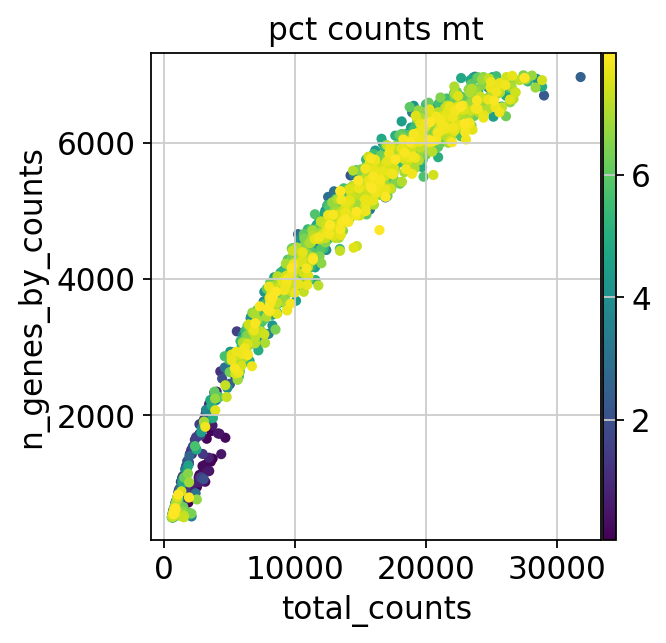

In [ ]:
# Plot QC metrics after filtering
p1 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [ ]:
# Save the filtered data.
adata.write(os.path.join(outdir_path, f"{output_prefix}.h5ad"))

In [ ]:
# Create a gene log
gene_log = dict(starting_genes=adata.n_vars)

In [ ]:
# Filter genes if min_cells is provided and add to gene log
if min_cells is not None:
    sc.pp.filter_genes(adata, min_cells=min_cells)
    gene_log["num_genes_after_qc"] = adata.n_vars

In [ ]:
# Save gene log
pd.DataFrame.from_dict(gene_log, orient="index").to_csv(
    os.path.join(outdir_path, "gene_log.csv")
)